In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np

In [5]:
obs_folder = "observables3D"
q_folder = "overlaps3D"
num_replicas = 6
max_points = int(1e5)
N = 5**2

In [6]:
T1 = 0.1
TM = 2.0
temperatures_x = [T1 * (TM / T1) ** (i / (num_replicas-1)) for i in range(num_replicas)]
temperatures_x

[0.1,
 0.18205642030260805,
 0.3314454017339987,
 0.6034176336545163,
 1.098560543306118,
 2.0]

# Gráficas

In [7]:
def plotObservables(temp: int, folder: str, show=True, save=False, figsize=(25, 10)):
    """
    Plots the time series of energy and magnetization at a specific replica index.
    Now supports files where each line contains: energy magnetization
    """
    filename = os.path.join(folder, f"observables_{temp}_1.txt")
    temperature = 0
    energies = []
    magnetizations = []

    with open(filename, 'r') as file:
        lines = file.readlines()
        temperature = float(lines[0].strip())
        for line in lines[1:max_points + 1]:
            try:
                energy, magnetization = map(float, line.strip().split())
                energies.append(energy)
                magnetizations.append(magnetization)
            except ValueError:
                print(f"Warning: Skipping malformed line: {line.strip()}")

    plt.figure(figsize=figsize)

    # Subplot for Energy
    plt.subplot(2, 1, 1)
    plt.plot(energies, label=f"T = {temperature:.3f}", color='tab:blue')
    plt.ylabel("Energy")
    plt.title(f"Energy evolution at T = {temperature:.3f} (first {max_points} steps)")
    plt.grid(True)

    # Subplot for Magnetization
    plt.subplot(2, 1, 2)
    plt.plot(magnetizations, label=f"T = {temperature:.3f}", color='tab:red')
    plt.xlabel("Monte Carlo step")
    plt.ylabel("Magnetization")
    plt.title(f"Magnetization evolution at T = {temperature:.3f} (first {max_points} steps)")
    plt.grid(True)

    plt.tight_layout()

    if save:
        plots_folder = "plots3D"
        os.makedirs(plots_folder, exist_ok=True)
        plot_path = os.path.join(plots_folder, f"energy_magnetization_plot_T{temp}.png")
        plt.savefig(plot_path)
        print(f"Plot saved to {plot_path}")

    if show:
        plt.show()
    else:
        plt.close()


In [8]:
for i in range(num_replicas):
    plotObservables(i, obs_folder, False, True)

Plot saved to plots3D\energy_magnetization_plot_T0.png
Plot saved to plots3D\energy_magnetization_plot_T1.png
Plot saved to plots3D\energy_magnetization_plot_T2.png
Plot saved to plots3D\energy_magnetization_plot_T3.png
Plot saved to plots3D\energy_magnetization_plot_T4.png
Plot saved to plots3D\energy_magnetization_plot_T5.png


In [9]:
# replicas_to_plot = 3

# energy_data = []
# magnetization_data = []
# temperatures = []

# for i in range(replicas_to_plot):
#     filename = os.path.join(folder, f"energies_{i}.txt")
#     with open(filename, 'r') as file:
#         lines = file.readlines()
#         temperature = float(lines[0].strip())
#         energies = []
#         magnetizations = []
#         for line in lines[1:max_points + 1]:
#             try:
#                 energy, magnetization = map(float, line.strip().split())
#                 energies.append(energy)
#                 magnetizations.append(magnetization)
#             except ValueError:
#                 print(f"Warning: Skipping malformed line in {filename}: {line.strip()}")
#         temperatures.append(temperature)
#         energy_data.append(energies)
#         magnetization_data.append(magnetizations)

# # Plotting
# plt.figure(figsize=(25, 12))

# # Energy subplot
# plt.subplot(2, 1, 1)
# for i in range(replicas_to_plot):
#     plt.plot(energy_data[i], label=f"T = {temperatures[i]:.3f}")
# plt.ylabel("Energy")
# plt.title(f"Parallel Tempering: Energy Time Series (first {max_points} steps)")
# plt.legend()
# plt.grid(True)

# # Magnetization subplot
# plt.subplot(2, 1, 2)
# for i in range(replicas_to_plot):
#     plt.plot(magnetization_data[i], label=f"T = {temperatures[i]:.3f}")
# plt.xlabel("Monte Carlo step")
# plt.ylabel("Magnetization")
# plt.title(f"Parallel Tempering: Magnetization Time Series (first {max_points} steps)")
# plt.legend()
# plt.grid(True)

# plt.tight_layout()
# plt.show()


# Autocorrelación

Para un observable A(t), la función de autocorrelación es:

$$
C_A(\tau) = \frac{\langle A(t)A(t + \tau) \rangle - \langle A(t) \rangle ^2}{\langle A(t) ^2 \rangle - \langle A(t)  \rangle ^2}
$$

El tiempo de autocorrelación nos da la cantidad de Monte Carlo Sweeps (MCS) que hay que hacer para que dos elementos de la cadena de Markov no estén correlacionados (o al menos no fuertemente?). Se calcula:

$$
\tau^{int}_{auto} = \frac{1}{2} + \sum_{\tau = 1}^{\infty} C_A(\tau)
$$

Como no podemos sumar hasta infinito, sumamos hasta ```max_lag```.





In [10]:
def calculateAutocorrelation(observable, max_lag: int):
    """
    Calcula autocorrelación *normalizada* hasta max_lag.

    energies: array que representa la secuencia de energías
    max_lag: entero hasta el que se considera tau
    """
    N = len(observable)
    mean = np.mean(observable)
    var = np.var(observable)

    C = np.zeros(max_lag)
    for tau in range(max_lag):
        C[tau] = np.mean((observable[:N - tau] - mean) * (observable[tau:] - mean)) / var
    return C

def integrated_time(C):
    """
    calcula la integrated auto correlation en base a la autocorrelación normalizada.

    C: array de autocorrelaciones
    """
    tau_int = 0.5
    for tau in range(1, len(C)):
        if C[tau] <= 0: break
        tau_int += C[tau]
    return tau_int

def autocorrelation_and_integrated_time_by_replica(folder: str, max_lag: int, burnin = 0.5):
    taus_E = []
    taus_M = []
    E_means = []
    Cvs = [] # heat capacities
    M_means = []

    for i in range(num_replicas):
        filename = os.path.join(folder, f"observables_{i}_2.txt")
        with open(filename, 'r') as file:
            lines = file.readlines()
            temperature = float(lines[0].strip())
            energies = []
            magnetizations = []
            for line in lines[1:max_points + 1]:
                try:
                    e, m = map(float, line.strip().split())
                    energies.append(e)
                    magnetizations.append(m)
                except ValueError:
                    continue

        start_idx = int(len(energies) * burnin)
        energies = np.array(energies[start_idx:])
        magnetizations = np.array(magnetizations[start_idx:])

        C_E = calculateAutocorrelation(energies, max_lag)
        C_M = calculateAutocorrelation(magnetizations, max_lag)

        tau_E = integrated_time(C_E)
        tau_M = integrated_time(C_M)

        taus_E.append(tau_E)
        taus_M.append(tau_M)

        stride_E = max(1, int(round(tau_E * N)))
        stride_M = max(1, int(round(tau_M * N)))

        E_downsampled = energies[::stride_E]
        M_downsampled = magnetizations[::stride_M]
        E2_mean = np.mean(np.array(E_downsampled)**2)

        E_mean = np.mean(E_downsampled)
        M_mean = np.mean(M_downsampled)
        Cv = (E2_mean - E_mean**2) / (temperatures_x[i]**2)

        E_means.append(E_mean)
        M_means.append(M_mean)
        Cvs.append(Cv)

        # Print the tau values for each replica
        print(f"Replica {i}: tau_E = {tau_E}, tau_M = {tau_M}")

    return taus_E, taus_M, E_means, M_means, Cvs

In [11]:
taus_E, taus_M, E_means, M_means, Cvs = autocorrelation_and_integrated_time_by_replica(obs_folder, 200)

Replica 0: tau_E = 197.75590628838665, tau_M = 197.73304197511973
Replica 1: tau_E = 196.85780539167888, tau_M = 188.02461085974883
Replica 2: tau_E = 189.03671492479324, tau_M = 183.99077895974338
Replica 3: tau_E = 155.94069931541094, tau_M = 193.0814412145796
Replica 4: tau_E = 147.39670935210486, tau_M = 149.618408705592
Replica 5: tau_E = 109.33963081268176, tau_M = 135.9809988491246


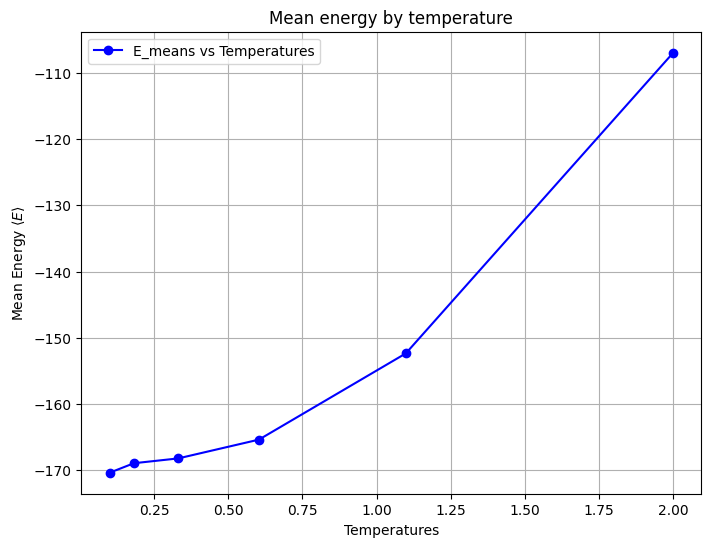

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(temperatures_x, E_means, marker='o', linestyle='-', color='b', label='E_means vs Temperatures')
plt.xlabel('Temperatures')
plt.ylabel(r'Mean Energy $\langle E \rangle$')
plt.title('Mean energy by temperature')
plt.grid(True)
plt.legend()
plt.show()

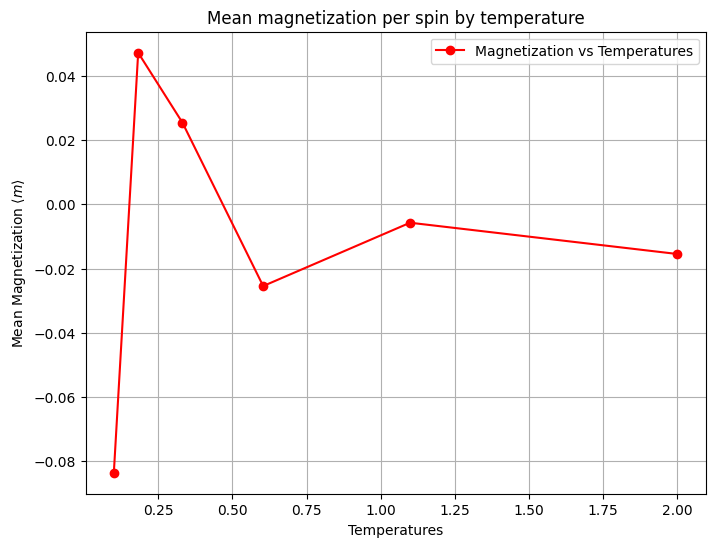

In [18]:
plt.figure(figsize=(8, 6))
plt.plot(temperatures_x, M_means, marker='o', linestyle='-', color='r', label='Magnetization vs Temperatures')
plt.xlabel('Temperatures')
plt.ylabel(r'Mean Magnetization $\langle m \rangle$')
plt.title('Mean magnetization per spin by temperature')
plt.grid(True)
plt.legend()
plt.show()

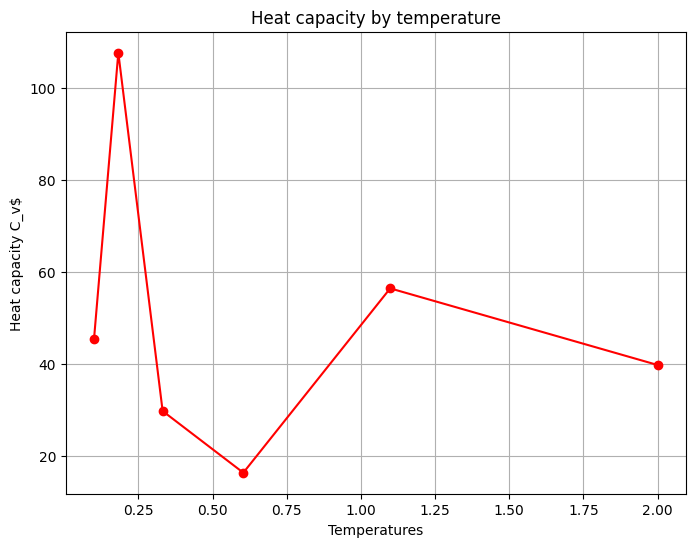

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(temperatures_x, Cvs, marker='o', linestyle='-', color='r')
plt.xlabel('Temperatures')
plt.ylabel(r'Heat capacity C_v$')
plt.title('Heat capacity by temperature')
plt.grid(True)
plt.show()

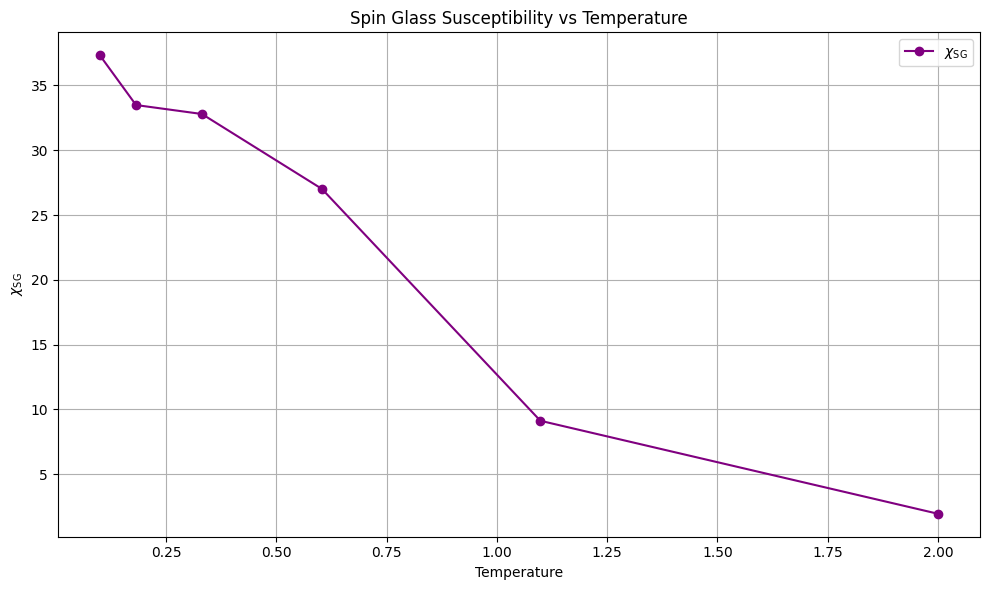

In [17]:
def compute_susceptibility(folder: str, taus_E, L, N_s=10, burnin_frac=0.5):
    chi_SG = []

    N = L * L  # total number of spins

    for i, tau in enumerate(taus_E):
        filepath = os.path.join(folder, f"overlaps_{i}.txt")
        with open(filepath, 'r') as f:
            q_values = np.array([float(line.strip()) for line in f if line.strip()])

        # Apply burn-in
        start = int(len(q_values) * burnin_frac)
        q_values = q_values[start:]

        # Downsample using stride tau * N_s
        stride = max(1, int(round(tau * N_s)))
        q_downsampled = q_values[::stride]

        # Compute susceptibility: chi_SG = N * <q^2>
        chi = N * np.mean(q_downsampled ** 2)
        chi_SG.append(chi)

    return chi_SG

# Example usage
L = 10               # lattice size
N_s = 10             # decorrelation multiplier
burnin = 0.5         # discard first 50%

chi_sg = compute_susceptibility("overlaps3D", taus_E, L, N_s, burnin)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(temperatures_x, chi_sg, 'o-', color='purple', label=r'$\chi_{\mathrm{SG}}$')
plt.xlabel('Temperature')
plt.ylabel(r'$\chi_{\mathrm{SG}}$')
plt.title('Spin Glass Susceptibility vs Temperature')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
